# ✅ Data Mining HW03 (231113)

- [과제 수행 내용]
- [데이터]
- [제출파일]: 해당 파일 내 코드 및 답변을 추가한 ipynb 파일 (hw02_answer_학번+이름.ipynb)
- [제출기한] 11월 19일 (일) 자정 (23:59까지)
- [유의사항]
  1. 제출 파일 형식에 맞춰 결과물을 정확히 제출할 것.
  2. 제출 기한을 엄수할 것.

---


#  KLUE: Korean GLUE Benchmark

Park, S., Moon, J., Kim, S., Cho, W. I., Han, J., Park, J., ... & Cho, K. (2021). Klue: Korean language understanding evaluation. arXiv preprint arXiv:2105.09680.

## Background

- https://huggingface.co/datasets/klue
- KLUE의 모체인 GLUE benchmark는 언어모델이 다양한 자연어처리 태스크를 얼마나 잘 수행하는지 확인하고자 만든 벤치마크 데이터셋입니다.
- 감성 분석, 텍스트 유사도, 추론 등 다양한 분야에 걸쳐 데이터셋을 구축하였습니다.
- KLUE benchmark는 영어로 이루어진 GLUE benchmark의 한계를 극복하고, 한국어 언어모델의 성능을 객관적 지표로 나타내고자 한 시도에서 탄생한 벤치마크 데이터셋입니다.
- 본 homework에서는 KLUE benchmark dataset을 전부 사용하지 않고, 그 중 nli (natural language inference) 데이터셋을 사용합니다.
- nli 데이터셋은 대전제(premise)가 주어졌을 때, 가정(hypothesis)가 대전제에 포함되는지, 포함되지 않는지, 중립인지를 분류하는 classification 분류에 해당하는 데이터셋입니다.
- hypothesis가 premise에 포함되면 entailment, 포함되지 않으면 contradiction, 중립이면 neutral로 분류됩니다.

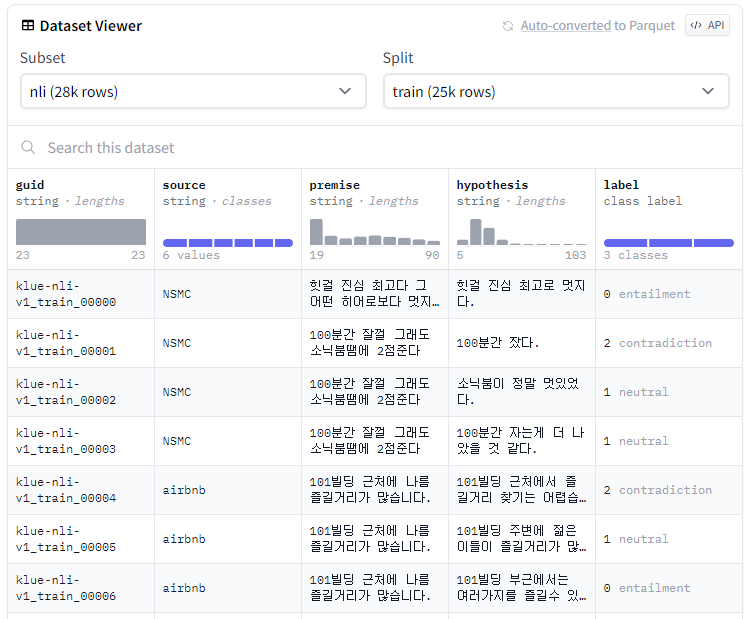

## Requirements

- 데이터셋을 불러오세요.
- 불러온 데이터셋을 적절하게 전처리하고, custom dataset과 dataloader를 구축하세요. (8점)
- 적절한 모델을 구축하세요. (10점)
- 적절한 하이퍼파라미터를 주고, 모델을 훈련 및 검증하세요. (12점)
- 결과에 대한 적절한 설명을 첨부하세요. (3점)

---

In [1]:
!pip install datasets
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import softmax

from transformers import AutoTokenizer, AutoModel

from sklearn.metrics import f1_score, accuracy_score, classification_report

---

# Load Dataset

In [3]:
# 데이터 주소: https://huggingface.co/datasets/klue

from datasets import load_dataset

datasets = load_dataset("klue", "nli") # klue dataset 중 nli를 가져오겠다는 의미

Generating train split:   0%|          | 0/24998 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [4]:
datasets

DatasetDict({
    train: Dataset({
        features: ['guid', 'source', 'premise', 'hypothesis', 'label'],
        num_rows: 24998
    })
    validation: Dataset({
        features: ['guid', 'source', 'premise', 'hypothesis', 'label'],
        num_rows: 3000
    })
})

# Preprocessing [8점]

In [5]:
from transformers import AutoTokenizer
# loading tokenizer
model_checkpoint = "klue/bert-base" # https://huggingface.co/klue/bert-base klue/RoBERTa-base 등도 가능

# AutoTokenizer를 이용하여 tokenizer를 불러오세요. (5점)
#-----your code-----#
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
#-----valid-----#
tokenizer

tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

BertTokenizerFast(name_or_path='klue/bert-base', vocab_size=32000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [6]:
# custom dataset class 정의
# 왜 tokenizer의 input sequence가 2개일까?: 하나는 premise, 다른 하나는 hypothesis로,
# tokenizer를 거치면 token_type_ids를 통해 앞 시퀀스인지, 뒤 시퀀스인지 구별 가능

class KlueNLIDataset(Dataset):
    def __init__(self, premise: list, hypothesis: list, label: list, tokenizer, max_len: int):
        self.premise = premise
        self.hypothesis = hypothesis
        self.label = label
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, idx):
        #-----your code-----#
        premise_sample = self.premise[idx]  # self.premise에서 idx에 해당하는 premise sample return
        hypothesis_sample = self.hypothesis[idx] # self.hypothesis에서 idx에 해당하는 hypothesis sample return
        label_sample =  self.label[idx] # self.label idx에 해당하는 label sample return
        #-------------------#

        inputs = self.tokenizer.encode_plus(
            #-----your code-----#
            premise_sample, # premise를 첫 번째 input으로 사용
            hypothesis_sample, # hypothesis를 두 번째 input으로 사용
            #-------------------#
            max_length = self.max_len, # input_max_length
            padding = "max_length", # padding 할 길이
            truncation = True, # truncation 여부
            return_token_type_ids = True, # token_type_ids: 첫 번째 시퀀스(0)인지, 두 번째 시퀀스(1)인지 표시
        )

        return {
            "input_ids": torch.tensor(inputs["input_ids"]),
            "attention_mask": torch.tensor(inputs["attention_mask"]),
            "token_type_ids": torch.tensor(inputs["token_type_ids"]),
            "targets": torch.tensor(label_sample)
        }

    def __len__(self): return len(self.label)

In [8]:
trainDS = KlueNLIDataset(premise = datasets["train"]["premise"],
                         hypothesis = datasets["train"]["hypothesis"],
                         label = datasets["train"]["label"],
                         tokenizer = tokenizer,
                         max_len = 512)
testDS = KlueNLIDataset(premise = datasets["validation"]["premise"],
                        hypothesis = datasets["validation"]["hypothesis"],
                        label = datasets["validation"]["label"],
                        tokenizer = tokenizer,
                        max_len = 512)

#-----your code-----#
trainDL = DataLoader(trainDS, batch_size=16, shuffle=True)
 # trainDS를 dataloader로 변환: batch size는 16, shuffle은 True로 설정
testDL = DataLoader(testDS, batch_size=16, shuffle=True) # testDS를 dataloader로 변환: batch size는 16, shuffle은 True로 설정
#-------------------#

In [9]:
#-----valid-----#
trainDS[0]

{'input_ids': tensor([    2,     1,  7254,  3841,  2062,   636,  3711, 12717,  2178,  2062,
         11980,  2062,     3,     1,  7254,  3841,  2200, 11980,  2062,    18,
             3,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [10]:
#-----valid-----#
batch = next(iter(trainDL))
batch

{'input_ids': tensor([[    2, 23645,  2075,  ...,     0,     0,     0],
         [    2,  1117,  2170,  ...,     0,     0,     0],
         [    2,  5878,  2125,  ...,     0,     0,     0],
         ...,
         [    2,  1504,  4044,  ...,     0,     0,     0],
         [    2, 23645,  2075,  ...,     0,     0,     0],
         [    2,  3666,  2073,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'targets': tensor([2, 0, 2, 1, 0, 0, 0, 1, 1, 2, 1, 2, 1, 0, 1, 1])}

In [11]:
#-----valid-----#
batch["attention_mask"].shape

torch.Size([16, 512])

# Modeling [10점]

`transformers` 라이브러리에서 `AutoModel`을 사용하겠습니다.

In [12]:
class KlueNLIClassifier(nn.Module):
    def __init__(self, model_checkpoint):
        super().__init__()
        #-----your code-----#
        # 필수적으로 들어가야 하는 layer는 AutoModel을 이용한 transformer layer와,
        self.transformer = AutoModel.from_pretrained(model_checkpoint)

        # 최종 classification을 위한 linear layer이며, 이 외에는 여러분의 재량에 맡깁니다.
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.transformer.config.hidden_size, 3)

        # textual similarity 등 복수의 sequence를 input으로 사용하는 모델은 BERT family의 [CLS] token을 최종 classification으로 사용합니다.

    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.transformer(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, return_dict=False)

        # Dropout 및 최종 분류 레이어 적용

        out = self.dropout(pooled_output)
        out = self.fc(out)

        #-------------------#
        return out

#-----your code-----#
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # cpu도 가능은 하겠지만, 학습에 너무 오래 걸리겠죠?
#-------------------#

model = KlueNLIClassifier(model_checkpoint)
model = model.to(device)

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

# Training & Validation [12점]

In [13]:
# hyperparameter setting
learning_rate = 1e-5
num_epochs = 1

#-----your code-----#
# multiclass classification task 에서 어떤 loss function을 사용할지 고민해보세요:
# e.g. Binary Cross Entropy, Cross Entropy, L2, L1 etc.
#다중 클래스 분류이므로 Cross Entropy사용
def loss_fn(preds, targets):
  return nn.CrossEntropyLoss()(preds, targets)
# 적절한 optimizer를 선택하고 argument를 적절하게 부여하세요.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#-------------------#

In [14]:
from tqdm import tqdm

def train(epoch):
    model.train()
    total_loss = 0

    for batch in tqdm(trainDL, desc=f"Epoch {epoch + 1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        targets = batch['targets'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask, token_type_ids)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(trainDL)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")

# training
num_epochs = 1  # 예시로 1 에폭만 진행하겠습니다.
for epoch in range(num_epochs):
    train(epoch)


Epoch 1: 100%|██████████| 1563/1563 [36:34<00:00,  1.40s/it]

Epoch 1, Average Loss: 0.6261


In [15]:
for epoch in tqdm(range(num_epochs)):
    train(epoch)

100%|██████████| 1/1 [36:55<00:00, 2215.39s/it]

Epoch 1, Average Loss: 0.3540


In [23]:
# validation
#-----your code-----#
# validation을 위한 적절한 코드를 작성하세요.
def validation():
    model.eval()
    total_loss = 0
    correct_predictions = 0
    fin_targets = []
    fin_outputs = []

    with torch.no_grad():
        for batch in tqdm(testDL, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(input_ids, attention_mask, token_type_ids)
            loss = loss_fn(outputs, targets)

            total_loss += loss.item()

            # Accuracy 계산
            _, predicted_labels = torch.max(outputs, 1)
            correct_predictions += (predicted_labels == targets).sum().item()

            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    avg_loss = total_loss / len(testDL)
    accuracy = correct_predictions / len(testDS)

    print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    return fin_outputs, fin_targets


#-------------------#

# Analysis [3점]

In [22]:
#-----your code for analysis using scikit-learn-----#
num_epochs = 1
for epoch in range(num_epochs):
    train(epoch)




Epoch 1: 100%|██████████| 1563/1563 [36:45<00:00,  1.41s/it]


Epoch 1, Average Loss: 0.1330


Validation: 100%|██████████| 188/188 [01:38<00:00,  1.90it/s]


---

In [24]:
num_epochs = 1
for epoch in range(num_epochs):
   fin_outputs, fin_targets = validation()

Validation: 100%|██████████| 188/188 [01:37<00:00,  1.93it/s]

Validation Loss: 0.6634, Accuracy: 0.7963


끝. </br>
과제 하시느라 고생하셨습니다. </br>
다음 시간에 뵙겠습니다.